# 第五章 非平稳序列的确定性分析
- X12-ARIMA 
    - 核心思想：X11(因素分解)+ARIMA
    - vs 残差自回归方法： 区别在于一个是用因素分解，一个是用OLS/ARIMA先拟合;相同点都是需要对拟合后的残差再进行一次回归
- 参考 https://stackoverflow.com/questions/36945324/python-statsmodels-x13-arima-analysis-attributeerror-dict-object-has-no-att 可知，x13_arima_analysis返回的结果类似seasonal_decompose 


- [statsmodels.tsa.x13.x13_arima_analysis](https://www.statsmodels.org/dev/generated/statsmodels.tsa.x13.x13_arima_analysis.html)

- 结论：没有现成库可以用，缺乏可以直接进行in-sample 和out-of-sample拟合的函数；方法更像是几种方法的集成，类似残差自回归；实际中，如果SARIMAX 参数调节足够好的话，足够来对数据进行拟合； 


In [1]:
import datetime
import pandas as pd
import numpy as np
import os
import matplotlib as  mpl
from dateutil.relativedelta  import relativedelta
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号




习题数据="./习题与案例数据/习题数据/"
案例数据="./习题与案例数据/案例数据/"
from statsmodels.tsa.stattools import acf,pacf,adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.x13 import x13_arima_analysis

from statsmodels.regression.linear_model import OLS

from statsmodels.tsa.seasonal import seasonal_decompose

/Users/pengju/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 使用Q_LB进行白噪音假设
def my_Q_LB(ts,out_lags_list=[10],p_threshold=0.05):
    from scipy.stats  import  chi2
    n=len(ts)
    acf_ts=acf(ts,nlags=n)

    list_df=[]
    for l in out_lags_list:
        q_lb=sum([n*(n+2)*acf_ts[k]**2/(n-k)  for k in range(1,l+1) ])
        p=1- chi2.cdf(q_lb,l)
        tmp_l=[l,q_lb,p,p>p_threshold]
        list_df.append(tmp_l)

    df=pd.DataFrame(list_df,columns=['延迟期数','Q_LB统计量','P值','接受白噪音假设'])
    return df
  
# 绘制acf图    
def my_plt_acf(ts,out_lags=10):
    acf_ts=acf(ts)[:out_lags+1]
    df=pd.Series(acf_ts)
    df.index+=1
    df.plot(title='acf',marker='o',grid=True)
    plt.axhline(y=0,color='red')
    plt.show()
    print(df)
    
# 生成adf校验表，判断序列是否平稳，类似参数书上P227；用来确定阶数
def adf_check_table(ts,max_lag=3,threshod=0.05):
    DICT_REGRESSION={'nc':'类型1',
                 'c':'类型2',
                 'ct':'类型3'}
    list_df=[]
    for i_reg in DICT_REGRESSION.keys():
        for i in range(max_lag+1):
            dftest=adfuller(ts,maxlag=i,regression=i_reg,autolag=None)
            dfoutput=pd.Series([DICT_REGRESSION[i_reg],i,'平稳' if dftest[1]<threshod else '非平稳']+list(dftest[0:4]),
                               index=['类型','延迟阶数','检验结果','Test Statistic','p-value','Lags Used',
            'Number of observations Used'])
            for key,value in dftest[4].items():
                dfoutput['Critical value(%s)'%key]=value
            list_df.append(dfoutput)
    return pd.concat(list_df,axis=1).transpose()    

# 仅限于ARIMA
def confidence_interval(results,steps=5,alpha=0.05):
    val,st,intv=results.forecast(steps=steps,alpha=alpha)
    return pd.DataFrame(np.concatenate([val.reshape(-1,1),st.reshape(-1,1),intv],axis=1),columns=['预测值','标准差','{:,.0%}置信区间下限'.format(alpha),'{:,.0%}置信区间上限'.format(alpha)])
    

## 例题 5-7 
- X13方法不可用 提示 X13NotFoundError: x12a and x13as not found on path. Give the path, put them on PATH, or set the X12PATH or X13PATH environmental variable.


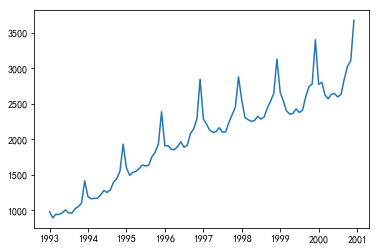

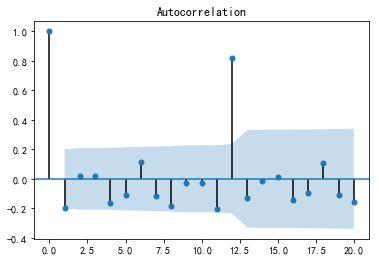

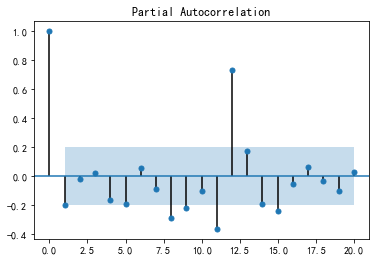

ar.L1       -0.550420
sigma2    3148.806469
dtype: float64


,延迟期数,Q_LB统计量,P值,接受白噪音假设
0,6,3.928268,0.686383,True
1,12,20.112627,0.064985,True
2,18,21.779364,0.241928,True


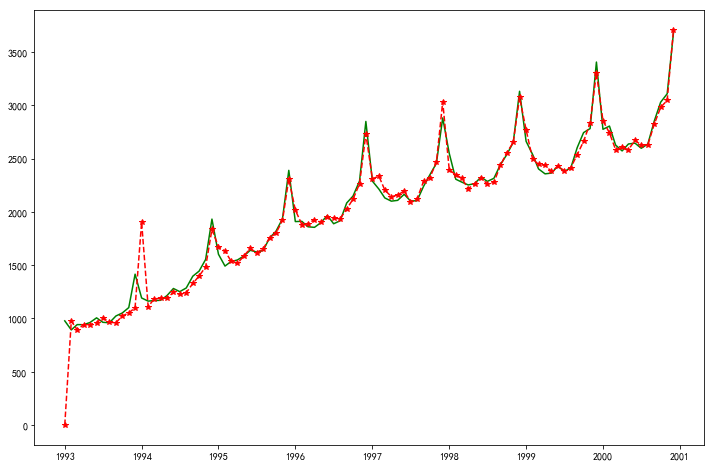

In [3]:
零售额=  pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.15.xls")).transpose().values.flatten())
零售额.index=[datetime.datetime(1993,1,1)+relativedelta(months=i) for i in range(len(零售额))]
plt.plot(零售额)
plt.show()

零售额差分=零售额.diff().dropna()
sm.graphics.tsa.plot_acf(零售额差分,lags=20)
plt.show()

sm.graphics.tsa.plot_pacf(零售额差分,lags=20)
plt.show()


model=SARIMAX(endog=零售额,order=(1,1,0),seasonal_order=(0,1,0,12))
results=model.fit()
print(results.params)
display(my_Q_LB(results.resid,out_lags_list=[6,12,18]))

plt.figure(figsize=(12,8))
plt.plot(零售额,color='g')
plt.plot(results.fittedvalues,color='r',marker='*',ls='dashed')
plt.show()


- seasonal_decompose： 加法和乘法的区别在于结果展示层面，趋势提取是一致的

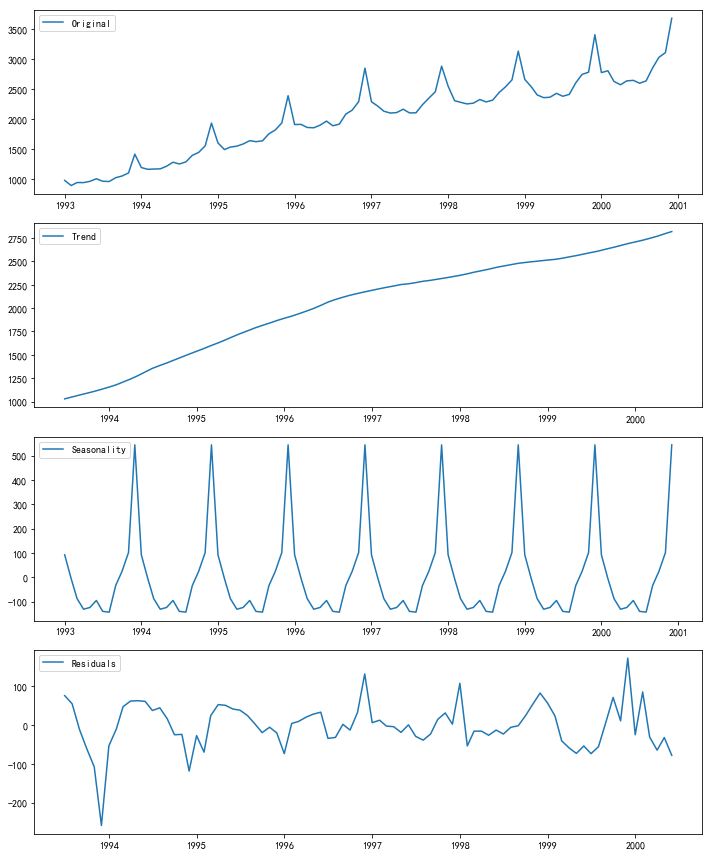

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(零售额,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,12))
plt.subplot(411)
plt.plot(零售额, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


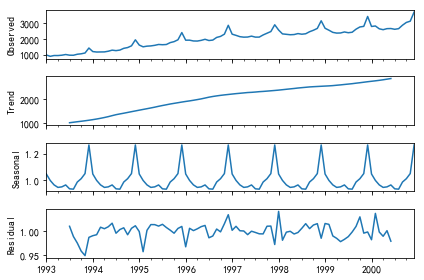

In [10]:
decomposition.plot()

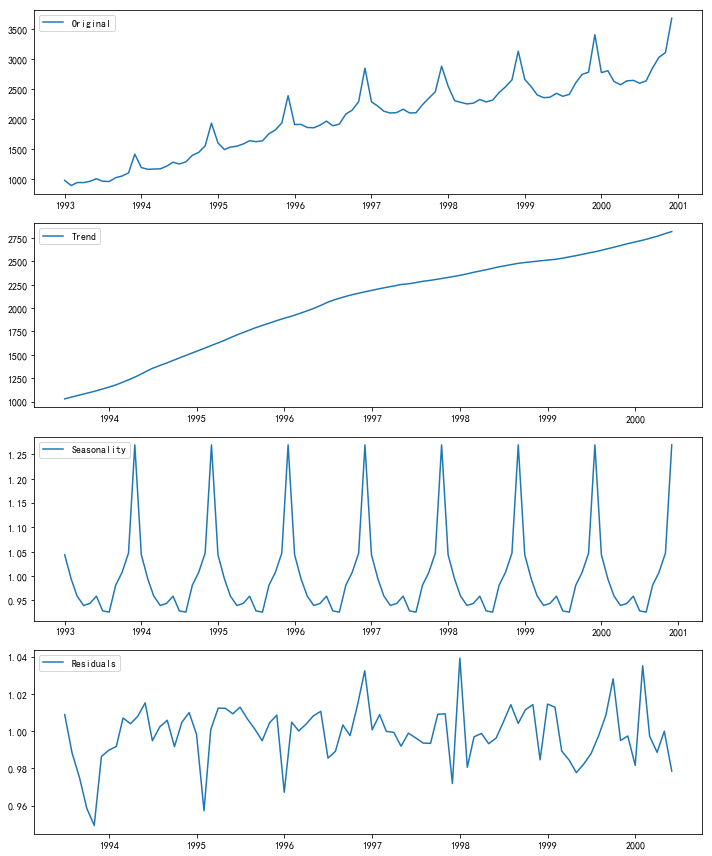

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(零售额,model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,12))
plt.subplot(411)
plt.plot(零售额, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [7]:
# import os
# os.chdir('/Users/pengju/Downloads/x13asall_V1.1_B39/')

import statsmodels.api as sm
sm.tsa.x13_arima_analysis(零售额)
         

X13NotFoundError: x12a and x13as not found on path. Give the path, put them on PATH, or set the X12PATH or X13PATH environmental variable.

In [ ]:
w